In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
import pylab as pl

## System of Equations

The equations of structure of an compact object with spherical symmetry (neutron stars in our case) is given by (in units where $c=G=1$):

$$ P=P(\rho), $$
$$ \frac{dm}{dr}=4\pi \rho r^2 , $$
$$ \frac{dP}{dr}=-(\rho+P)\frac{m+4\pi r^3 P}{r(r-2m)} , $$

and if is required


$$ \frac{d\nu}{dr}= \frac{m+4\pi r^3 P}{r(r-2m)} .$$


Nondimensionalizing the variables:


$r=b\bar{r} \quad ; \quad \rho=\Sigma \bar{\rho} \quad ; \quad m=m_*\bar{m} \quad ; \quad  P=P_* \bar{P}$ 

with $\Sigma=\Sigma(m_n)$.

So if we want just one parameter ($m_n$), given $\Sigma$, the other parameters $b$, $m_*$, $P_*$ are found by forcing the nondimensional equation to keep the same form:

$$ b=\frac{1}{\sqrt{\Sigma}} \quad ; \quad m_*=b \quad ; \quad P_*=\Sigma.$$

With a particular choice of $\Sigma$ and fixing the units with factors of $c$ and $G$ we have:


$$ \Sigma=\frac{m_{n}^{4}c^{3}}{8 \pi^2 \hbar^3}\quad;\quad b=\frac{c}{\sqrt{\Sigma G}}\quad, \quad m= \frac{b c^2}{G} \bar{m} \quad; \quad P= \Sigma c^2 \bar{P},$$

and the nondimensional system of equations keeps the same form:

$$ \bar{P}=\bar{P}(\bar{\rho}), $$
$$ \frac{d\bar{m}}{\bar{dr}}=4\pi \bar{\rho} \bar{r}^2 , $$
$$ \frac{d\bar{P}}{d\bar{r}}=-(\bar{\rho}+\bar{P})\frac{\bar{m}+4\pi \bar{r}^3 \bar{P}}{\bar{r}(\bar{r}-2\bar{m})} . $$

## Solving the system

To solve this system of equations we need two initial conditions:

$$ \bar{P}{(0)}=P_{c}{(\bar{\rho_{c}})} \quad ; \quad \bar{m}{(0)}=0,$$

depending on the choice of $\rho_{c}$.

We want our equation of state to be a table of numbers $(\rho_{i},P_{i})$, this equation of state will depend on the theoretical model used to study the interior of the neutron star.

Loading some constants (in cgs units) from a separeted file and declaring the parameters

In [2]:
import Physical_Const as phys
h=phys.h 
c=phys.c
G=phys.G
Msun=phys.Msun
mn=phys.mn # Neutron mass


Sigma=np.power(mn,4.0)*np.power(c,3.0)/ \
            (8.0*np.power(np.pi,2.0)*np.power(h/(2.0*np.pi),3.0))
br=c/np.sqrt(Sigma*G) 
Mdim=(br*np.power(c,2.0)/G)/Msun # So that m is measured in Solar masses

In [3]:
print(Sigma)

2280831545249651.0


and loading the equation of state and interpolating it linearly

In [4]:
rhoEoS,PEoS=np.loadtxt('EOSFull_NL3_BPS02.dat',usecols=(0,1),unpack=True) 

# Interpolating P
EoS_NL302=interpolate.interp1d(rhoEoS/Sigma,PEoS/(np.power(c,2.0)*Sigma)) 


# Interpolating Rho
EoS_NL3=interpolate.interp1d(PEoS/(np.power(c,2.0)*Sigma),rhoEoS/Sigma)

def rho_EoS(x):
    rhorho=interpolate.interp1d(PEoS/(np.power(c,2.0)*Sigma),rhoEoS/Sigma)
    return rhorho(x)

Comparing the table and the interpolation

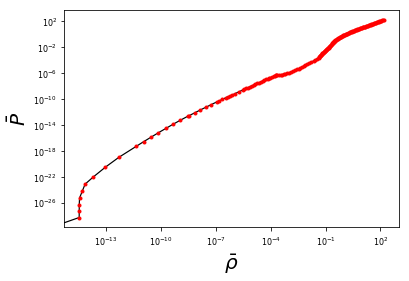

In [12]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.loglog(rhoEoS/Sigma,EoS_NL302(rhoEoS/Sigma),'k-', \
           linewidth=1.2,label="Interpolation") # Interpolación
plt.loglog(rhoEoS/Sigma,PEoS/(c**2*Sigma),'ro', \
           markersize=3,label='Data') # Valores de la tabla
plt.xlabel(r'$\bar{\rho}$')
plt.ylabel(r'$\bar{P}$')
plt.savefig('NL3EoS.png', format='png', dpi=1000)
#plt.savefig('NL3EoS.eps')
plt.show()
plt.clf()

With the equation of state interpolated we can declare the system of equations:

In [13]:
def TOV(r,y):
    mns = y[0]
    pns = y[1]
    nuns= y[2]
    dmdr=4.0*np.pi*np.power(r,2.0)*rho_EoS(pns)
    dnudr=(4.0*np.pi*np.power(r,3.0)*pns+mns)/(r*(r-2.0*mns))
    dpdr=-dnudr*(pns+rho_EoS(pns))
    return pl.array([dmdr,dpdr,dnudr])

Setting up the integration routine

In [16]:
dr=1e-4 # Step size
r0=dr/1000.0 # Initial point
#r0=0.0
rf=2.0 # Final point

Static=integrate.ode(TOV).set_integrator('dopri5',atol=1e-9) # Dopri  
            # (Dorman-Prince method) is a R-K method of order (4)5

def StaticSeq(y0):
    Static.set_initial_value(y0,r0)
    global mms,pexs,rs
    mms=[]; pexs=[];rs=[]
    mms.append(y0[0]); pexs.append(y0[1]); rs.append(r0)
    while Static.successful() and Static.t<rf and \
        EoS_NL3(Static.y[1])*Sigma>1e8 and Static.y[1]>0.0:
         #A condition over the density is included to stop 
         #the integration when P doesn't hit zero exactly
        
        Static.integrate(Static.t+dr)
        mms.append(Mdim*Static.y[0]);pexs.append(Static.y[1]); rs.append(Static.t)
    while Static.successful() and Static.t<rf and \
        EoS_NL3(Static.y[1])*Sigma>1e6 and Static.y[1]>0.0: 
            # A refinement of the integration
        
        
        Static.integrate(Static.t+dr/10.0) # Make step size smaller
        mms.append(Mdim*Static.y[0]);pexs.append(Static.y[1]); rs.append(Static.t)
        mstar=Static.y[0]
        rstar=Static.t
        nustar=np.log(1-2.0*Static.y[0]/Static.t)-Static.y[2]  
    return [mstar*Mdim,rstar*br*1e-5] 
    # Returns mass of the star in solar masses and radius of the star in km

We choose the values for $\rho_c$ we want to consider and integrate saving the different values of $M_{star}$ y $R_{star}$ (slow):

In [17]:
rhoc=pl.arange(14.1,15.5,0.05)
xc=EoS_NL302(np.power(10.0,rhoc)/Sigma) 

MM=[];RR=[]

for xcc in xc:
    MR=StaticSeq([0,xcc,0])
    print(MR)
    RR=RR+[MR[1]]
    MM=MM+[MR[0]]
 

[0.12532788911347092, 34.913441001825454]
[0.1577695252919249, 24.528028634448347]
[0.20019970497668554, 20.09172114219861]
[0.2532039080095809, 17.84245588177453]
[0.3169746963223939, 16.603828718696786]
[0.3897393302407121, 15.89750012059947]
[0.4741317121919875, 15.462425037807263]
[0.5738858557224412, 15.183393643927142]
[0.6934098994775721, 15.00547467152276]
[0.8417114400194575, 14.897070488882967]
[1.0263624420824402, 14.84505592591234]
[1.25619583624317, 14.837034988631874]
[1.5229863613095165, 14.8513754522547]
[1.8025085090446922, 14.855021332836797]
[2.0662030759058414, 14.818319468310763]
[2.2896493527352253, 14.730089158224933]
[2.4656513129251505, 14.594219341866863]
[2.5965569857542437, 14.421890719688182]
[2.6888794282680384, 14.22428399214055]
[2.749924631843809, 14.011364566148272]
[2.786305524391109, 13.789938085464513]
[2.8035118963947685, 13.565351841609642]
[2.80589825083111, 13.341251715165708]
[2.796895107792101, 13.1203113518929]
[2.7791941252995773, 12.9047182

Finally we plot the M-R relation

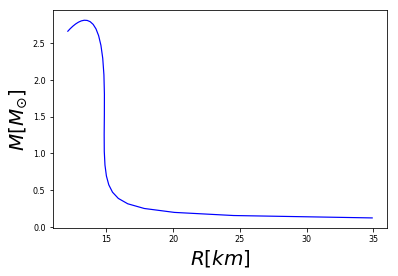

In [65]:
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1)

plt.plot(RR, MM,'b-', linewidth=1.2) 
plt.xlabel(r'$R [km]$')
plt.ylabel(r'$M [M_{\odot}]$')
plt.savefig('MRrel_NL3.png', format='png', dpi=1000)
#plt.savefig('MRrel_NL3.eps')
plt.show()
plt.clf()